<a href="https://www.kaggle.com/code/francescoliveras/ps-s5-e10-eda-model-en-es?scriptVersionId=267804615" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🛣️ Playground Series S5E10

## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Library import</p>
<a id="library-import"></a>

In [1]:

import os
import gc
import sys
import math
import time
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm
import lightgbm as lgb
import category_encoders as ce

from typing import Dict, List

from IPython.display import display

from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Constants</p>
<a id="constants"></a>

In [2]:

# Paths
KAGGLE_INPUT_PATH = Path("/kaggle/input/playground-series-s5e10")
LOCAL_INPUT_PATH = Path("playground-series-s5e10")

DATA_DIR = KAGGLE_INPUT_PATH if KAGGLE_INPUT_PATH.exists() else LOCAL_INPUT_PATH

TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"
SAMPLE_SUBMISSION_FILENAME = "sample_submission.csv"

TARGET = "accident_risk"
ID_COLUMN = "id"
PRIMARY_METRIC = "rmse"
SEED = 180
N_SPLITS = 5
PAIRPLOT_SAMPLE = 5000

# Palette reproduced from Plantilla.ipynb
yellow = "#F7C53E"
cyan_g = "#0CF7AF"
cyan_dark = "#11AB7C"
purple = "#D826F8"
purple_dark = "#9309AB"
purple_light = "#b683d6"
blue = "#0C97FA"
red = "#FA1D19"
orange = "#FA9F19"
green = "#0CFA58"
light_blue = "#01FADC"
soft_blue = "#81c9e6"
dark_blue = "#394be6"

PALETTE_2 = [cyan_g, purple]
PALETTE_3 = [yellow, cyan_g, purple]
PALETTE_4 = [yellow, orange, purple, light_blue]
PALETTE_5 = [purple_dark, purple_light, purple, blue, light_blue]
PALETTE_6 = [blue, red, orange, green, light_blue, purple]
PALETTE_7 = [purple_dark, purple_light, purple, blue, light_blue, dark_blue, soft_blue]
PALETTE_7_C = [purple_dark, blue, purple, light_blue, purple_light, soft_blue, dark_blue]

sns.set_style("whitegrid")
sns.set_palette(PALETTE_7)
plt.style.use({"figure.facecolor": "#f8fafc"})

pd.set_option("display.float_format", "{:.4f}".format)
warnings.filterwarnings("ignore")


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Functions</p>
<a id="functions"></a>


**EN:** Seed all relevant random number generators to stabilise experiments.
**ES:** Inicializa los generadores aleatorios para estabilizar los experimentos.


In [3]:

def set_seed(seed: int = SEED) -> None:
    """Seed Python, NumPy, and OS-level randomness for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ.setdefault("PYTHONHASHSEED", str(seed))



**EN:** Resolve dataset locations for Kaggle or local execution.
**ES:** Resuelve la ubicación de los datasets tanto en Kaggle como en local.


In [4]:

def get_paths() -> Dict[str, Path]:
    paths = {
        "train": DATA_DIR / TRAIN_FILENAME,
        "test": DATA_DIR / TEST_FILENAME,
        "sample": DATA_DIR / SAMPLE_SUBMISSION_FILENAME,
    }
    for name, path in paths.items():
        if not path.exists():
            raise FileNotFoundError(f"{name} file not found at {path}")
    return paths



**EN:** Load CSV files into pandas DataFrames.
**ES:** Carga los CSV como DataFrames de pandas.


In [5]:

def load_datasets(paths: Dict[str, Path]) -> Dict[str, pd.DataFrame]:
    return {name: pd.read_csv(path) for name, path in paths.items()}



**EN:** Utility to echo messages in English and Spanish.
**ES:** Utilidad para mostrar mensajes en inglés y español.


In [6]:

def bilingual_print(en: str, es: str) -> None:
    print(f"EN> {en}")
    print(f"ES> {es}")



**EN:** Estimate DataFrame memory usage in MB.
**ES:** Estima el consumo de memoria del DataFrame en MB.


In [7]:

def memory_usage_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / 1024**2



**EN:** Create a structural overview table for a dataset.
**ES:** Crea una tabla estructural con el resumen del dataset.


In [8]:

def dataset_profile(df: pd.DataFrame, name: str) -> pd.DataFrame:
    profile = pd.DataFrame({
        "dataset": name,
        "column": df.columns,
        "dtype": df.dtypes.astype(str),
        "n_unique": df.nunique(dropna=False),
        "missing_pct": (df.isna().mean() * 100).round(3),
    })
    return profile



**EN:** Cast boolean columns to categorical labels for modelling.
**ES:** Convierte columnas booleanas en etiquetas categóricas para modelado.


In [9]:

def convert_booleans_to_category(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = df_copy[col].map({True: "True", False: "False"}).astype("category")
    return df_copy



**EN:** Split features into numeric and categorical groups.
**ES:** Separa las variables en grupos numéricos y categóricos.


In [10]:

def get_feature_groups(train_df: pd.DataFrame, target: str, id_column: str) -> Dict[str, List[str]]:
    features_df = train_df.drop(columns=[target])
    numeric = features_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical = features_df.select_dtypes(include=["object", "category"]).columns.tolist()
    for col in [id_column]:
        if col in numeric:
            numeric.remove(col)
        if col in categorical:
            categorical.remove(col)
    return {"numeric": numeric, "categorical": categorical}



**EN:** Construct preprocessing pipeline for numeric and categorical features.
**ES:** Construye el pipeline de preprocesado para variables numéricas y categóricas.


In [11]:

def build_preprocessor(feature_groups: Dict[str, List[str]]) -> ColumnTransformer:
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    transformers = []
    if feature_groups["numeric"]:
        transformers.append(("numeric", numeric_pipeline, feature_groups["numeric"]))
    if feature_groups["categorical"]:
        transformers.append(("categorical", categorical_pipeline, feature_groups["categorical"]))

    return ColumnTransformer(transformers=transformers, remainder="drop")



**EN:** Visualize missing data patterns.
**ES:** Visualiza los patrones de valores faltantes.


In [12]:

def plot_missing_values(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 4))
    msno.bar(df, color=PALETTE_7_C)
    plt.title("Missing Values Overview / Valores Faltantes")
    plt.tight_layout()
    plt.show()



**EN:** Inspect target behaviour via histogram and boxplot.
**ES:** Revisa el comportamiento del objetivo mediante histograma y boxplot.


In [13]:

def plot_target_distribution(df: pd.DataFrame, target: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(df[target], bins=30, kde=True, color=PALETTE_7[2], ax=axes[0])
    axes[0].set_title("Target Distribution")
    sns.boxplot(x=df[target], color=PALETTE_7[4], ax=axes[1])
    axes[1].set_title("Target Boxplot")
    plt.tight_layout()
    plt.show()



**EN:** Display correlation structure among numeric features.
**ES:** Muestra la estructura de correlaciones entre variables numéricas.


In [14]:

def plot_correlation_heatmap(df: pd.DataFrame, target: str) -> None:
    numeric_df = df.select_dtypes(include=["number"])
    corr = numeric_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, mask=mask, cmap=PALETTE_2, annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation / Correlación de Variables")
    plt.tight_layout()
    plt.show()



**EN:** Analyse categorical distributions and target impact.
**ES:** Analiza distribuciones categóricas e impacto en el objetivo.


In [15]:

def plot_categorical_summary(df: pd.DataFrame, categorical_cols: List[str], target: str) -> None:
    if not categorical_cols:
        bilingual_print("No categorical features to profile.", "No hay variables categóricas para perfilar.")
        return

    for col in categorical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, order=order, palette=PALETTE_7, ax=axes[0])
        axes[0].set_title(f"{col} — counts")
        axes[0].tick_params(axis='x', rotation=30)
        sns.barplot(data=df, x=col, y=target, order=order, palette=PALETTE_7_C, ax=axes[1])
        axes[1].set_title(f"{col} vs {target} (mean)")
        axes[1].tick_params(axis='x', rotation=30)
        plt.tight_layout()
        plt.show()



**EN:** Inspect numeric features versus the target.
**ES:** Inspecciona las variables numéricas frente al objetivo.


In [16]:

def plot_numeric_distributions(df: pd.DataFrame, numeric_cols: List[str], target: str) -> None:
    if not numeric_cols:
        bilingual_print("No numeric features to profile.", "No hay variables numéricas para perfilar.")
        return

    n_cols = 2
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    plt.figure(figsize=(16, 5 * n_rows))
    for idx, col in enumerate(numeric_cols, 1):
        ax = plt.subplot(n_rows, n_cols, idx)
        sns.scatterplot(data=df, x=col, y=target, color=PALETTE_7[idx % len(PALETTE_7)], alpha=0.6, ax=ax)
        sns.regplot(data=df, x=col, y=target, scatter=False, lowess=True, color=PALETTE_7_C[idx % len(PALETTE_7_C)], ax=ax)
        ax.set_title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()



**EN:** Pairwise numeric relationships with optional sampling.
**ES:** Relaciones numéricas pareadas con muestreo opcional.


In [17]:

def plot_pairgrid(df: pd.DataFrame, columns: List[str], sample_size: int = PAIRPLOT_SAMPLE) -> None:
    if len(columns) < 2:
        bilingual_print("Not enough numeric features for pairplot.", "No hay suficientes variables numéricas para pairplot.")
        return
    sample_df = df[columns].sample(min(len(df), sample_size), random_state=SEED)
    sns.pairplot(sample_df, diag_kind="kde", corner=True, plot_kws={"alpha": 0.5, "s": 20, "color": PALETTE_7[3]})
    plt.suptitle("Pairplot of Numeric Features", y=1.02)
    plt.show()



**EN:** Generate aggregated target statistics per categorical feature.
**ES:** Genera estadísticas agregadas del target por variable categórica.


In [18]:

def feature_group_statistics(df: pd.DataFrame, group_col: str, target: str) -> pd.DataFrame:
    agg = df.groupby(group_col)[target].agg(["count", "mean", "median", "std"]).reset_index()
    agg = agg.sort_values("mean", ascending=False)
    return agg



**EN:** Cross-validate candidate models and summarise metrics.
**ES:** Valida cruzadamente los modelos candidatos y resume métricas.


In [19]:

def evaluate_models(models: Dict[str, object], X: pd.DataFrame, y: pd.Series, preprocessor: ColumnTransformer, n_splits: int = N_SPLITS) -> pd.DataFrame:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    results = []
    for name, estimator in models.items():
        fold_metrics = []
        start = time.time()
        for train_idx, valid_idx in cv.split(X, y):
            pipeline = Pipeline([
                ("preprocessor", clone(preprocessor)),
                ("model", clone(estimator)),
            ])
            pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
            preds = pipeline.predict(X.iloc[valid_idx])
            rmse = mean_squared_error(y.iloc[valid_idx], preds, squared=False)
            mae = mean_absolute_error(y.iloc[valid_idx], preds)
            fold_metrics.append((rmse, mae))
        duration = time.time() - start
        rmses, maes = zip(*fold_metrics)
        results.append({
            "model": name,
            "rmse_mean": float(np.mean(rmses)),
            "rmse_std": float(np.std(rmses)),
            "mae_mean": float(np.mean(maes)),
            "fit_time_sec": duration,
        })
    leaderboard = pd.DataFrame(results).sort_values("rmse_mean").reset_index(drop=True)
    return leaderboard



**EN:** Fit a preprocessing + model pipeline on training data.
**ES:** Entrena el pipeline de preprocesado y modelo sobre los datos de entrenamiento.


In [20]:

def train_best_pipeline(model: object, preprocessor: ColumnTransformer, X_train: pd.DataFrame, y_train: pd.Series) -> Pipeline:
    pipeline = Pipeline([
        ("preprocessor", clone(preprocessor)),
        ("model", clone(model)),
    ])
    pipeline.fit(X_train, y_train)
    return pipeline



**EN:** Assess hold-out performance with multiple metrics.
**ES:** Evalúa el rendimiento hold-out con varias métricas.


In [21]:

def evaluate_holdout(pipeline: Pipeline, X_valid: pd.DataFrame, y_valid: pd.Series) -> Dict[str, float]:
    preds = pipeline.predict(X_valid)
    return {
        "rmse": mean_squared_error(y_valid, preds, squared=False),
        "mae": mean_absolute_error(y_valid, preds),
        "r2": r2_score(y_valid, preds),
    }



**EN:** Clamp predictions to a valid target range.
**ES:** Ajusta las predicciones al rango válido del objetivo.


In [22]:

def clip_predictions(preds: np.ndarray, lower: float = 0.0, upper: float = 1.0) -> np.ndarray:
    return np.clip(preds, lower, upper)



**EN:** Create and persist the Kaggle submission file.
**ES:** Crea y guarda el archivo de submission para Kaggle.


In [23]:

def generate_submission(pipeline: Pipeline, test_features: pd.DataFrame, test_ids: pd.Series, target: str, filename: str = "submission.csv") -> pd.DataFrame:
    predictions = clip_predictions(pipeline.predict(test_features))
    submission = pd.DataFrame({ID_COLUMN: test_ids, target: predictions})
    submission.to_csv(filename, index=False)
    return submission


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Data import</p>
<a id="data-agent"></a>

In [24]:

set_seed(SEED)
paths = get_paths()
data = load_datasets(paths)

train_df = data["train"].copy()
test_df = data["test"].copy()
sample_submission_df = data["sample"].copy()

bilingual_print(
    f"Loaded train shape {train_df.shape} and test shape {test_df.shape}.",
    f"Cargadas train {train_df.shape} y test {test_df.shape}."
)

train_memory = memory_usage_mb(train_df)
test_memory = memory_usage_mb(test_df)
bilingual_print(
    f"Train memory usage: {train_memory:.2f} MB | Test memory usage: {test_memory:.2f} MB.",
    f"Uso de memoria train: {train_memory:.2f} MB | Uso de memoria test: {test_memory:.2f} MB."
)

bilingual_print("Train head (top 5 rows).", "Train head (primeras 5 filas).")
display(train_df.head())

bilingual_print("Train tail (last 5 rows).", "Train tail (últimas 5 filas).")
display(train_df.tail())

bilingual_print("Sample submission preview.", "Vista previa del sample submission.")
display(sample_submission_df.head())

validate_columns = set(sample_submission_df.columns)
assert TARGET in validate_columns, "Target column missing in sample submission"


EN> Loaded train shape (517754, 14) and test shape (172585, 13).
ES> Cargadas train (517754, 14) y test (172585, 13).
EN> Train memory usage: 149.94 MB | Test memory usage: 48.66 MB.
ES> Uso de memoria train: 149.94 MB | Uso de memoria test: 48.66 MB.
EN> Train head (top 5 rows).
ES> Train head (primeras 5 filas).


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.0600,35,daylight,rainy,False,True,afternoon,False,True,1,0.1300
1,1,urban,4,0.9900,35,daylight,clear,True,False,evening,True,True,0,0.3500
2,2,rural,4,0.6300,70,dim,clear,False,True,morning,True,False,2,0.3000
3,3,highway,4,0.0700,35,dim,rainy,True,True,morning,False,False,1,0.2100
4,4,rural,1,0.5800,60,daylight,foggy,False,False,evening,True,False,1,0.5600


EN> Train tail (last 5 rows).
ES> Train tail (últimas 5 filas).


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
517749,517749,highway,4,0.1000,70,daylight,foggy,True,True,afternoon,False,False,2,0.3200
517750,517750,rural,4,0.4700,35,daylight,rainy,True,True,morning,False,False,1,0.2600
517751,517751,urban,4,0.6200,25,daylight,foggy,False,False,afternoon,False,True,0,0.1900
517752,517752,highway,3,0.6300,25,night,clear,True,False,afternoon,True,True,3,0.5100
517753,517753,highway,2,0.3100,45,dim,rainy,False,True,afternoon,True,True,2,0.2200


EN> Sample submission preview.
ES> Vista previa del sample submission.


,id,accident_risk
0,517754,0.3520
1,517755,0.3520
2,517756,0.3520
3,517757,0.3520
4,517758,0.3520


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Data analysis</p>
<a id="analysis-agent"></a>

In [25]:

profile_table = dataset_profile(train_df, "train")
summary_stats = train_df.describe(include="all").T

bilingual_print(
    "Dataset profile with dtypes, uniques, and missing percentages.",
    "Perfil del dataset con tipos, valores únicos y porcentajes de nulos."
)
display(profile_table)

bilingual_print(
    "Descriptive statistics (numeric and categorical).",
    "Estadísticos descriptivos (numéricos y categóricos)."
)
display(summary_stats)

categorical_cols = train_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)
if ID_COLUMN in numeric_cols:
    numeric_cols.remove(ID_COLUMN)


EN> Dataset profile with dtypes, uniques, and missing percentages.
ES> Perfil del dataset con tipos, valores únicos y porcentajes de nulos.


,dataset,column,dtype,n_unique,missing_pct
id,train,id,int64,517754,0.0000
road_type,train,road_type,object,3,0.0000
num_lanes,train,num_lanes,int64,4,0.0000
curvature,train,curvature,float64,261,0.0000
speed_limit,train,speed_limit,int64,5,0.0000
lighting,train,lighting,object,3,0.0000
weather,train,weather,object,3,0.0000
road_signs_present,train,road_signs_present,bool,2,0.0000
public_road,train,public_road,bool,2,0.0000
time_of_day,train,time_of_day,object,3,0.0000


EN> Descriptive statistics (numeric and categorical).
ES> Estadísticos descriptivos (numéricos y categóricos).


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,517754.0000,NaN,NaN,NaN,258876.5000,149462.8500,0.0000,129438.2500,258876.5000,388314.7500,517753.0000
road_type,517754,3,highway,173672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lanes,517754.0000,NaN,NaN,NaN,2.4915,1.1204,1.0000,1.0000,2.0000,3.0000,4.0000
curvature,517754.0000,NaN,NaN,NaN,0.4887,0.2726,0.0000,0.2600,0.5100,0.7100,1.0000
speed_limit,517754.0000,NaN,NaN,NaN,46.1126,15.7885,25.0000,35.0000,45.0000,60.0000,70.0000
lighting,517754,3,dim,183826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,517754,3,foggy,181463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_signs_present,517754,2,False,259289,NaN,NaN,NaN,NaN,NaN,NaN,NaN
public_road,517754,2,True,260045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_of_day,517754,3,morning,173410,NaN,NaN,NaN,NaN,NaN,NaN,NaN


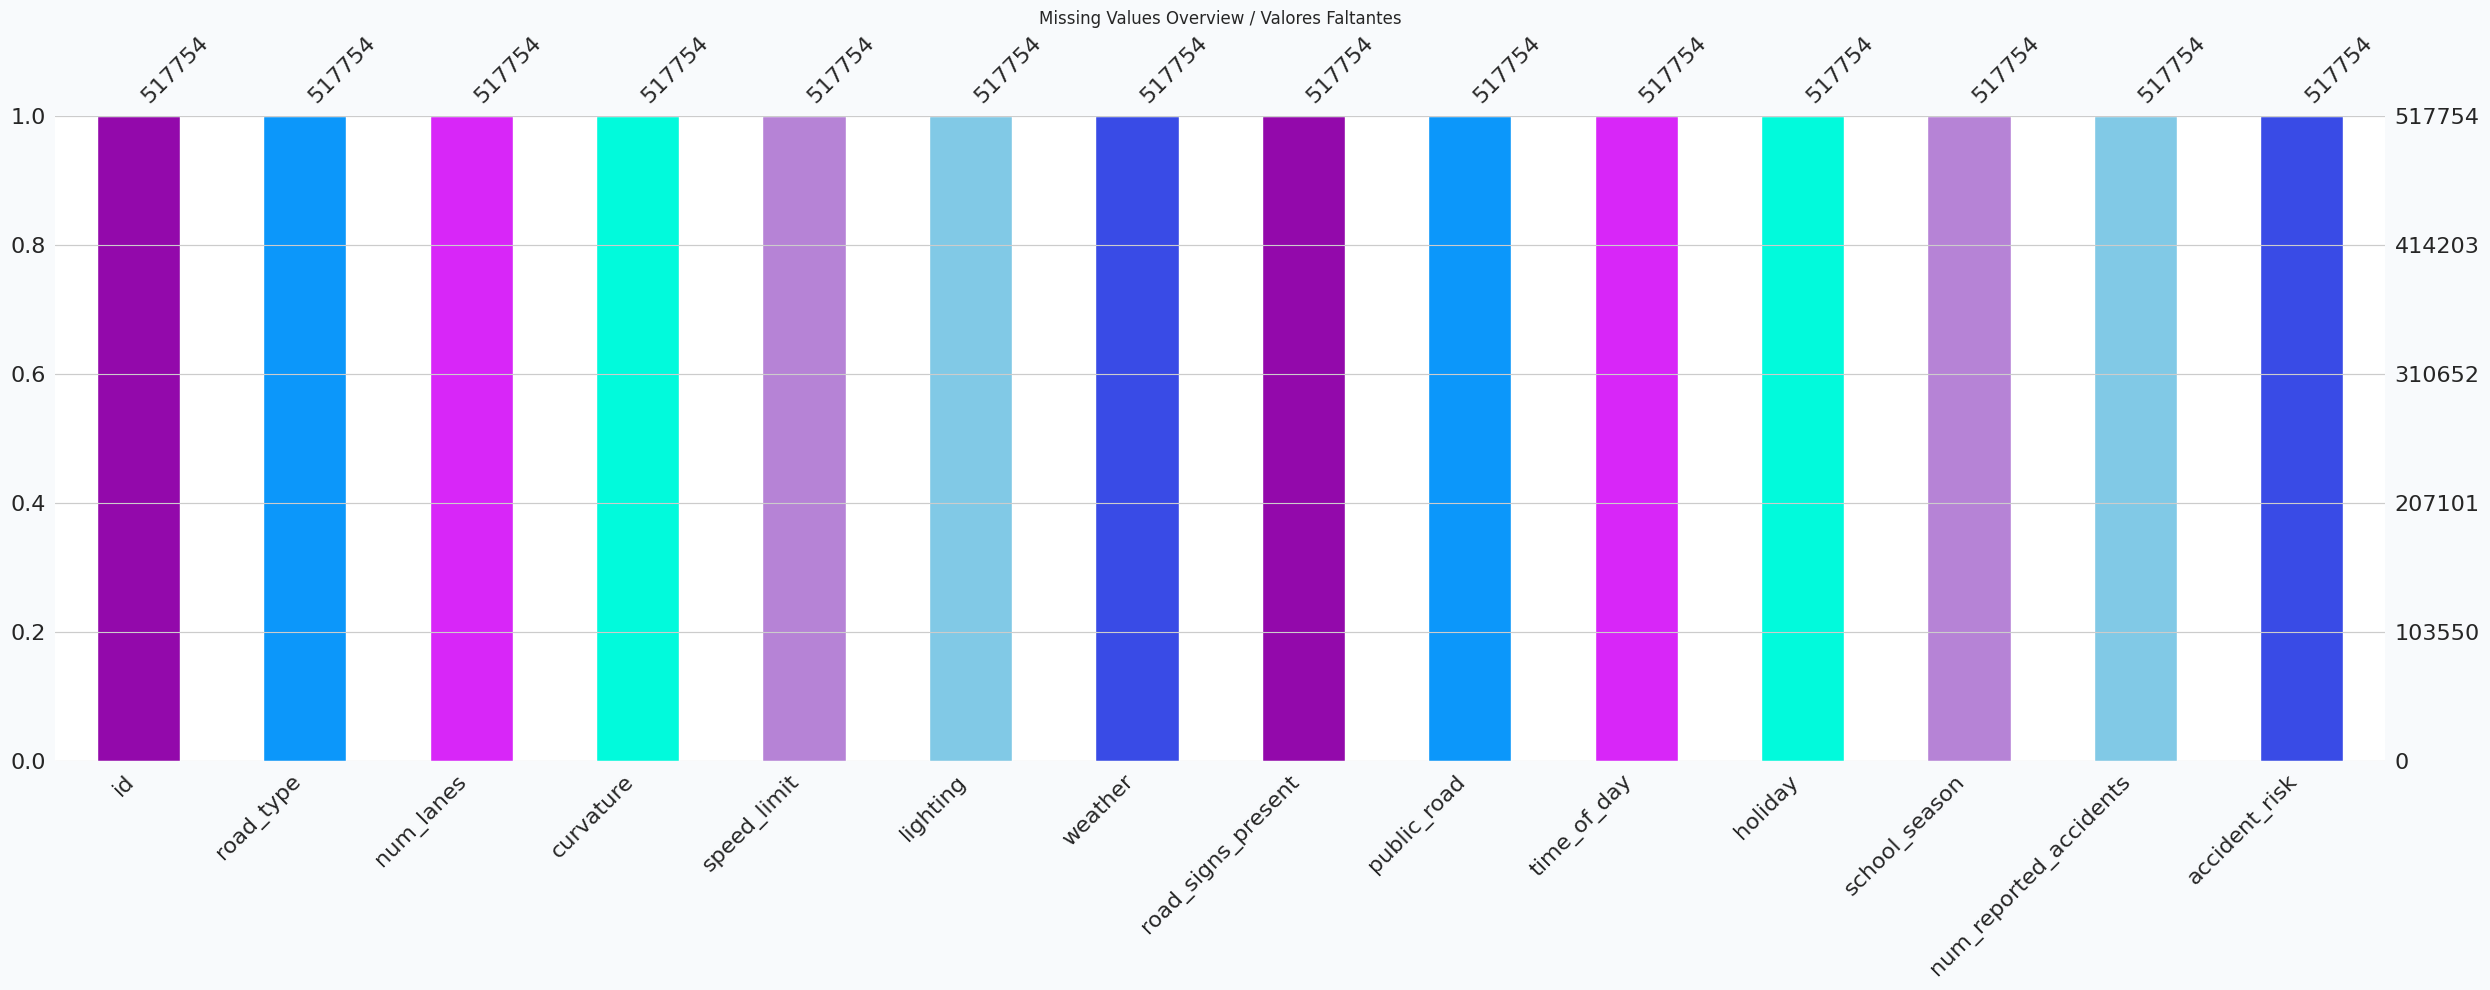

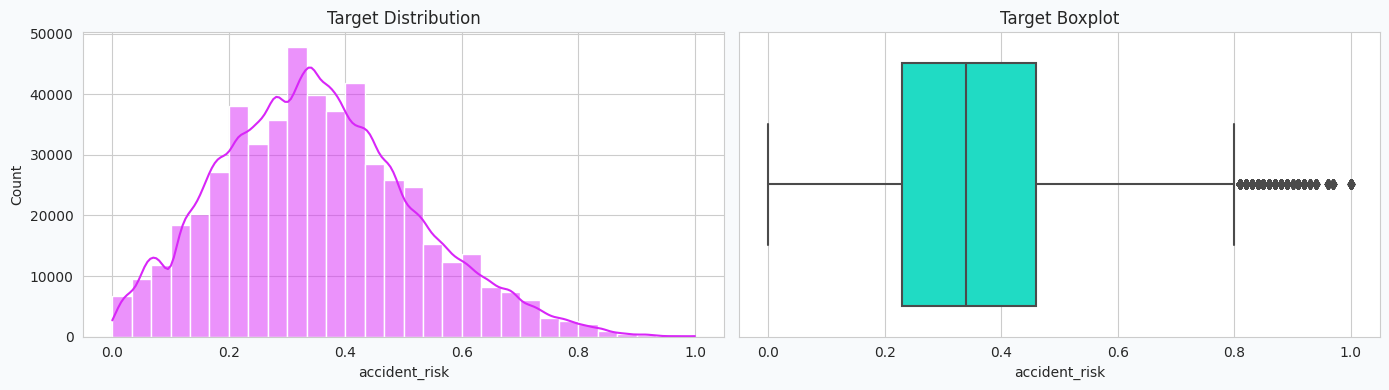

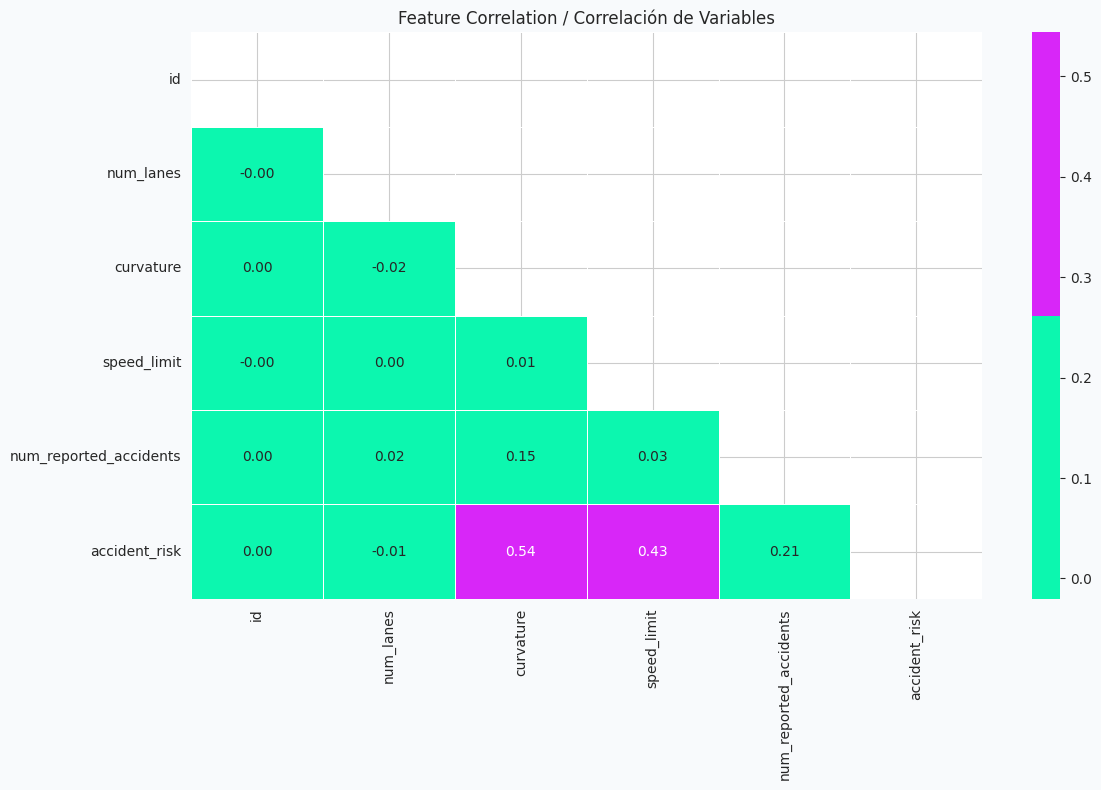

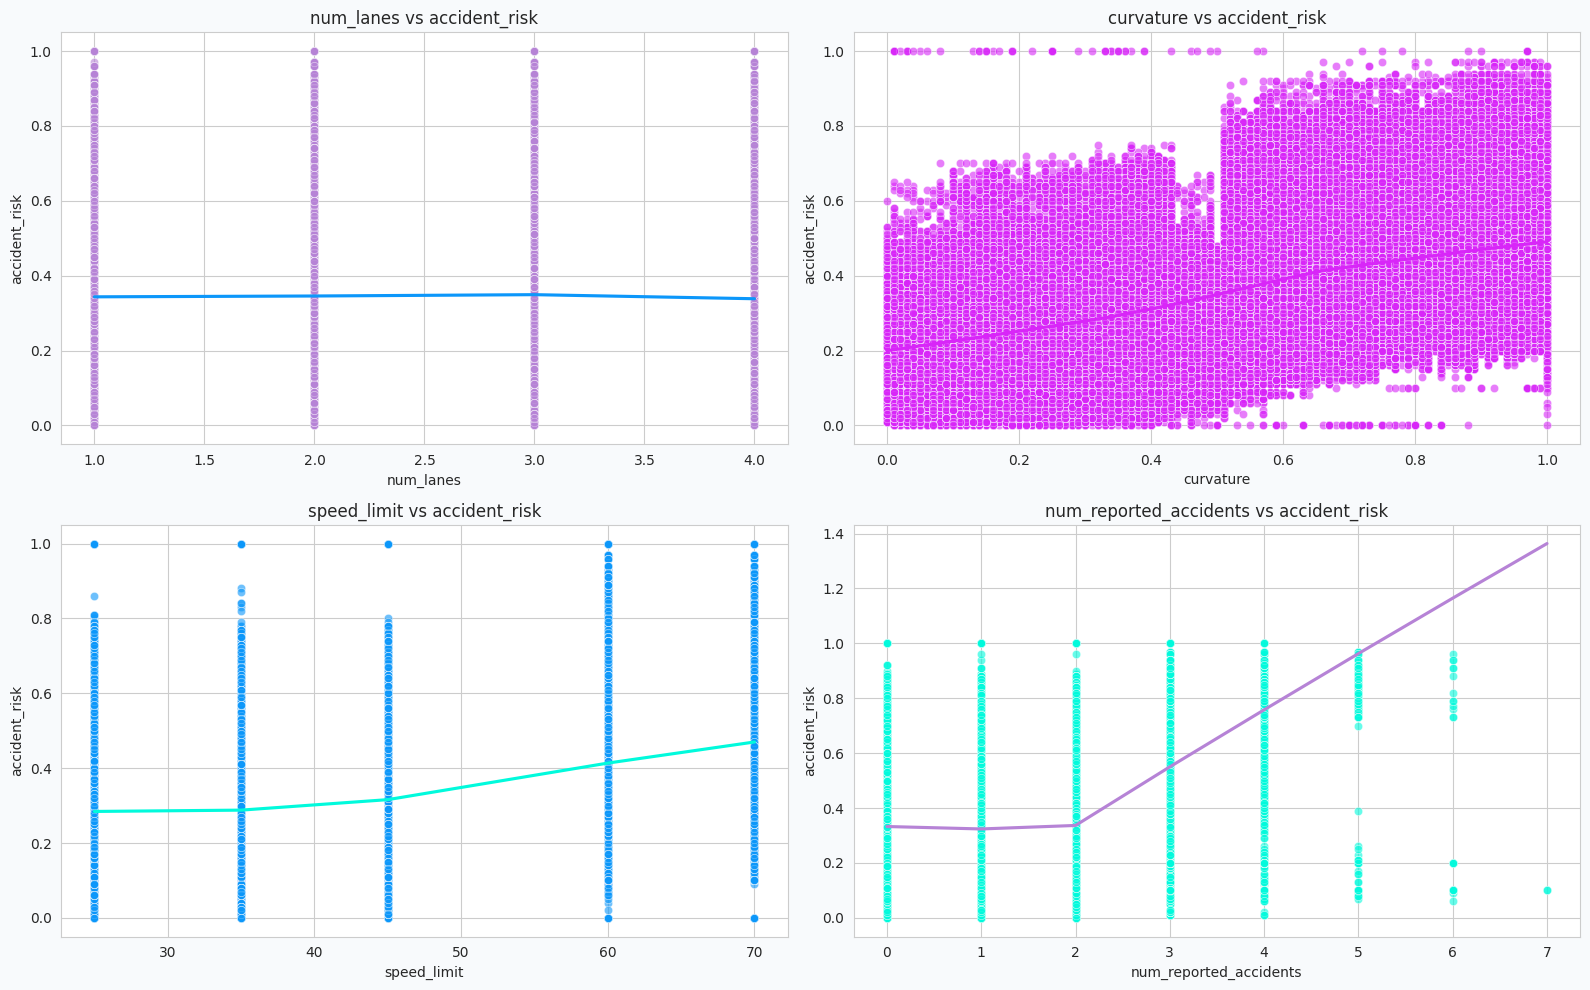

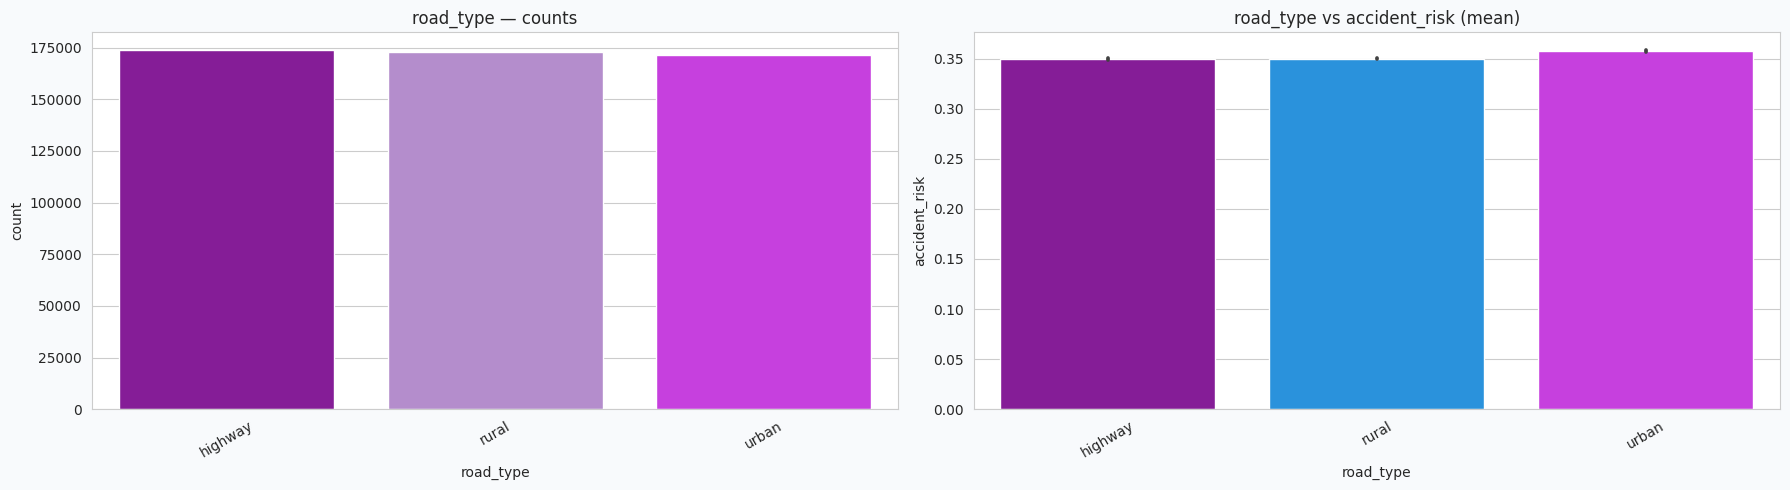

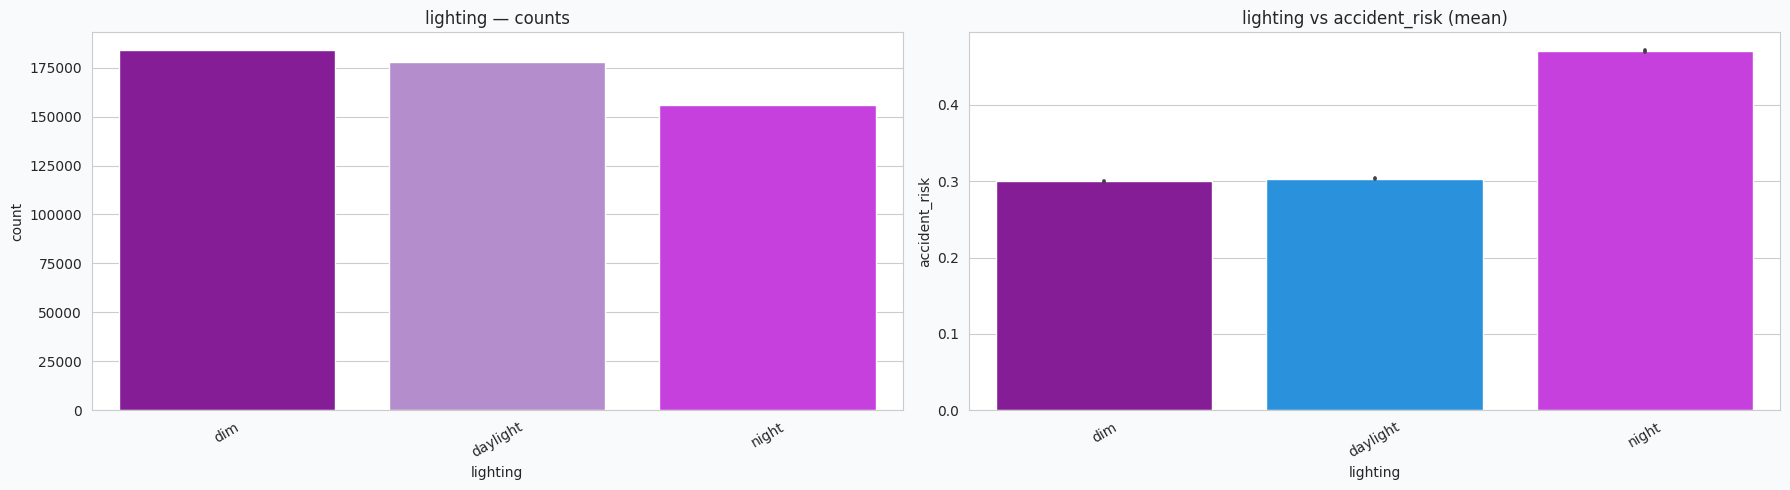

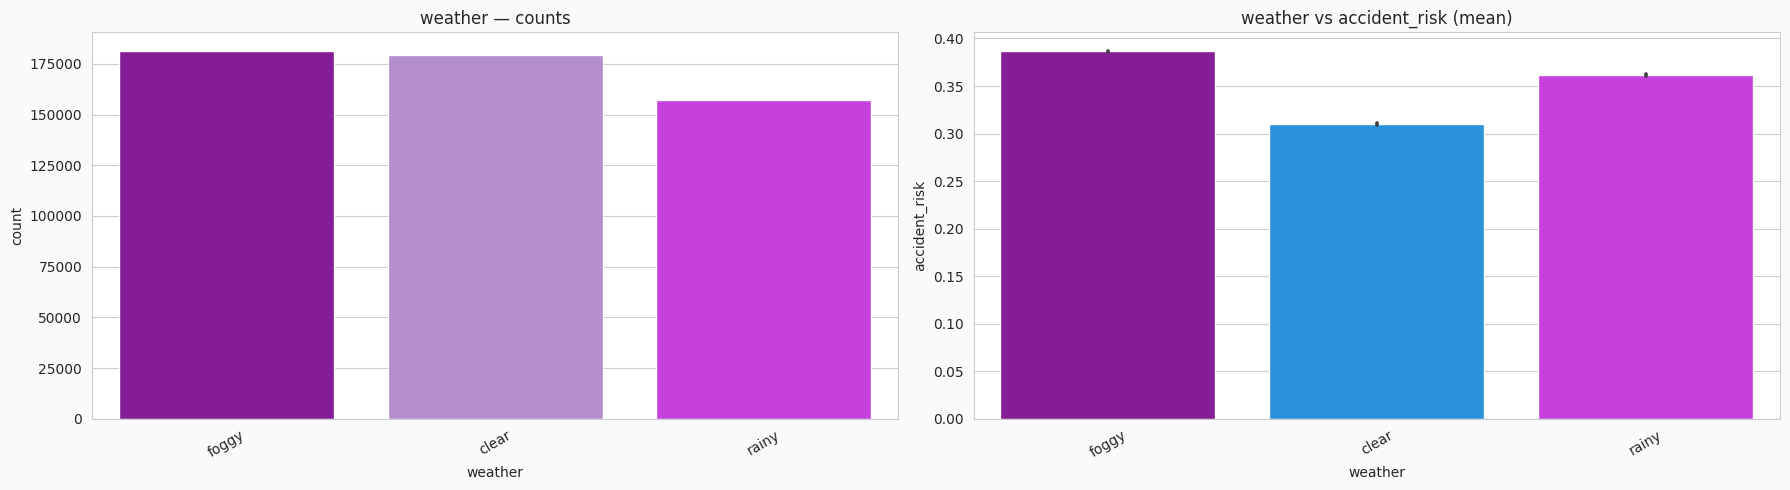

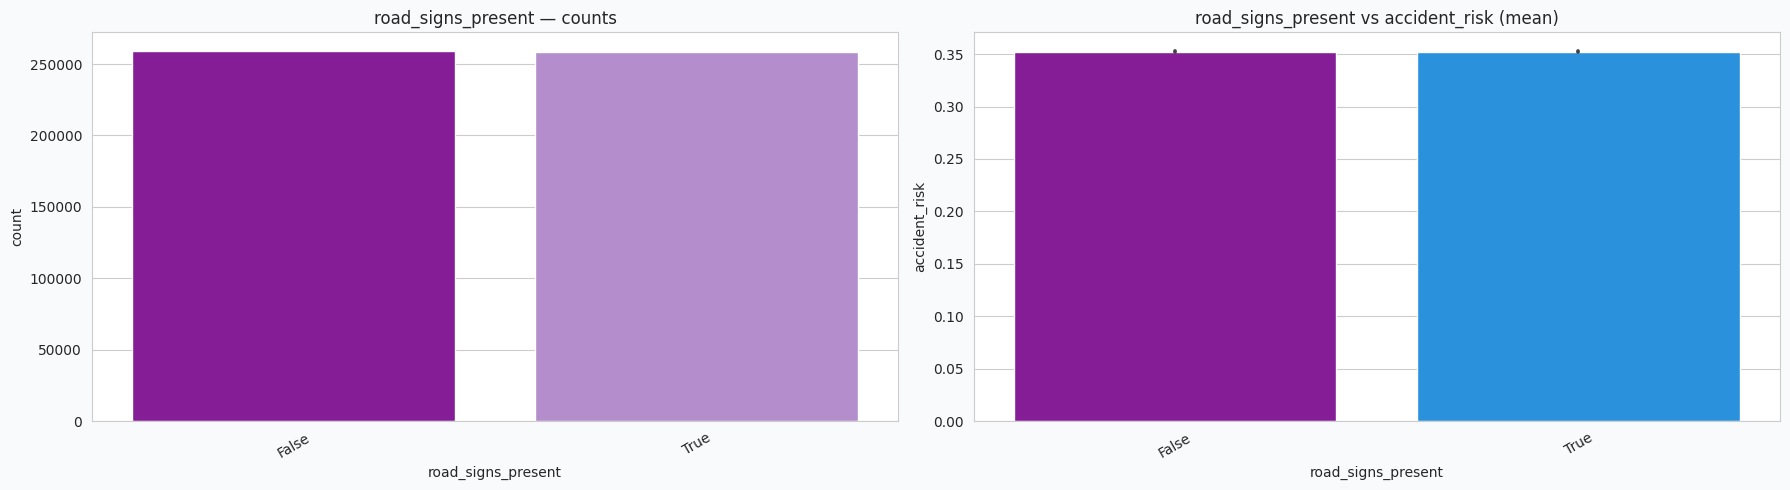

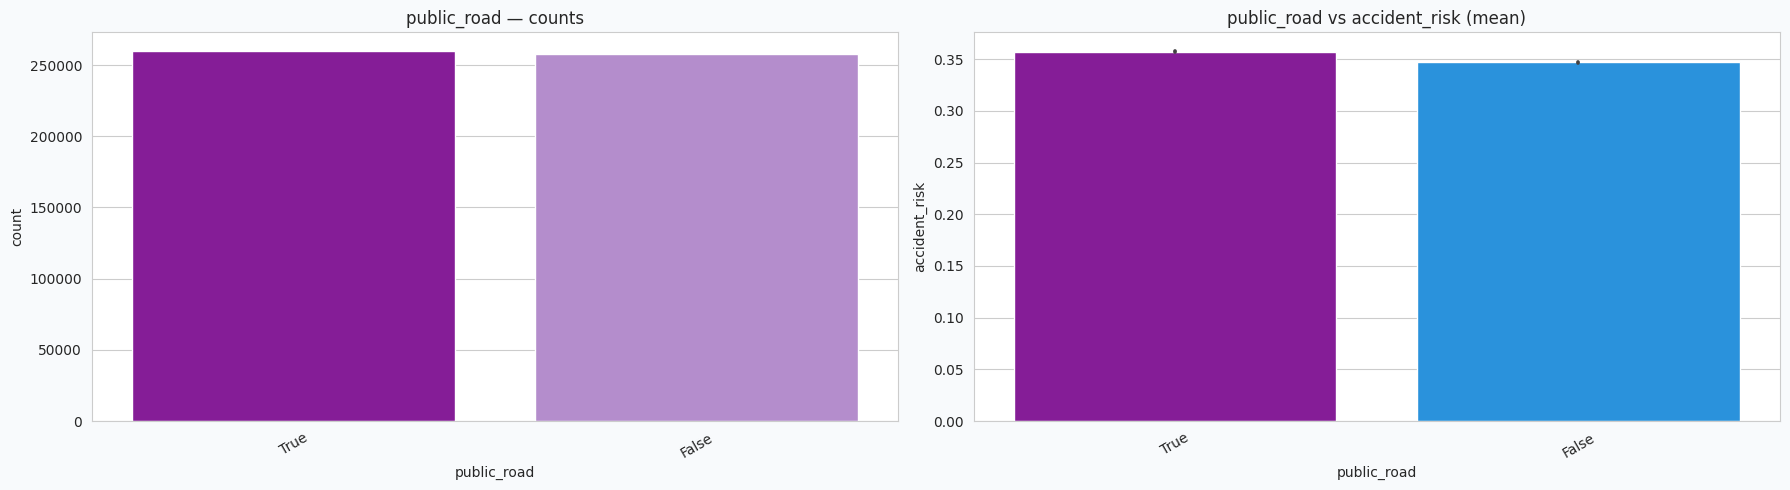

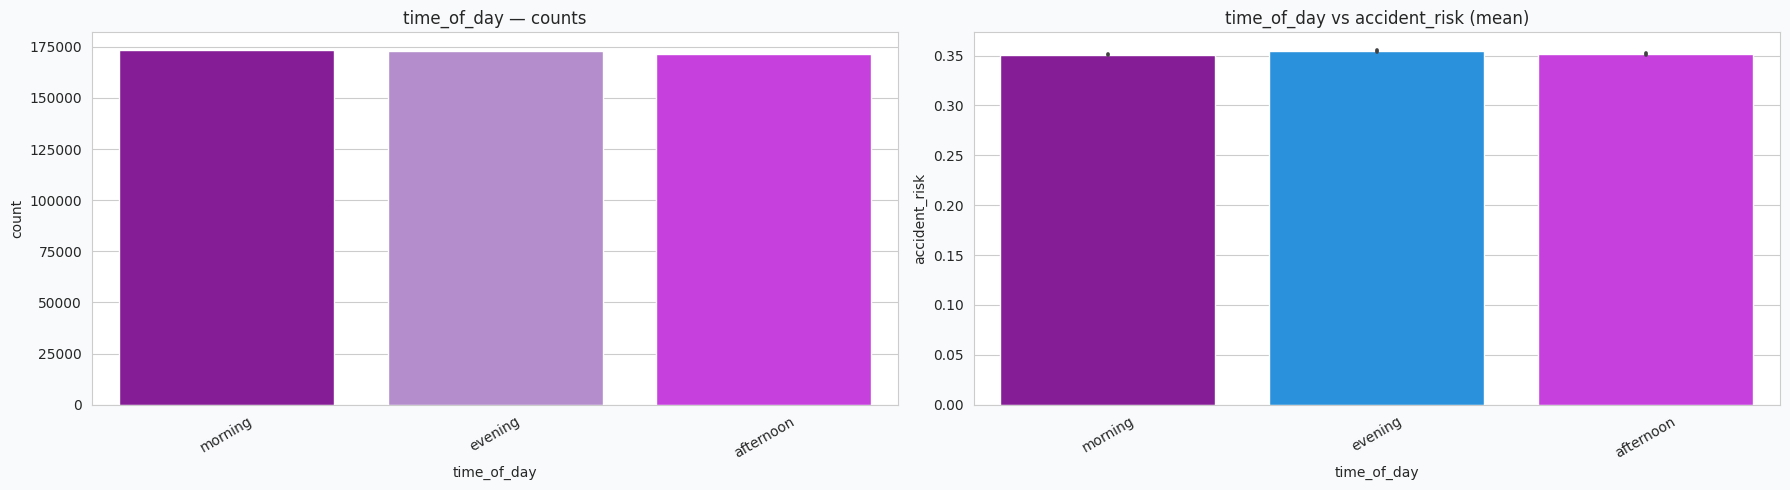

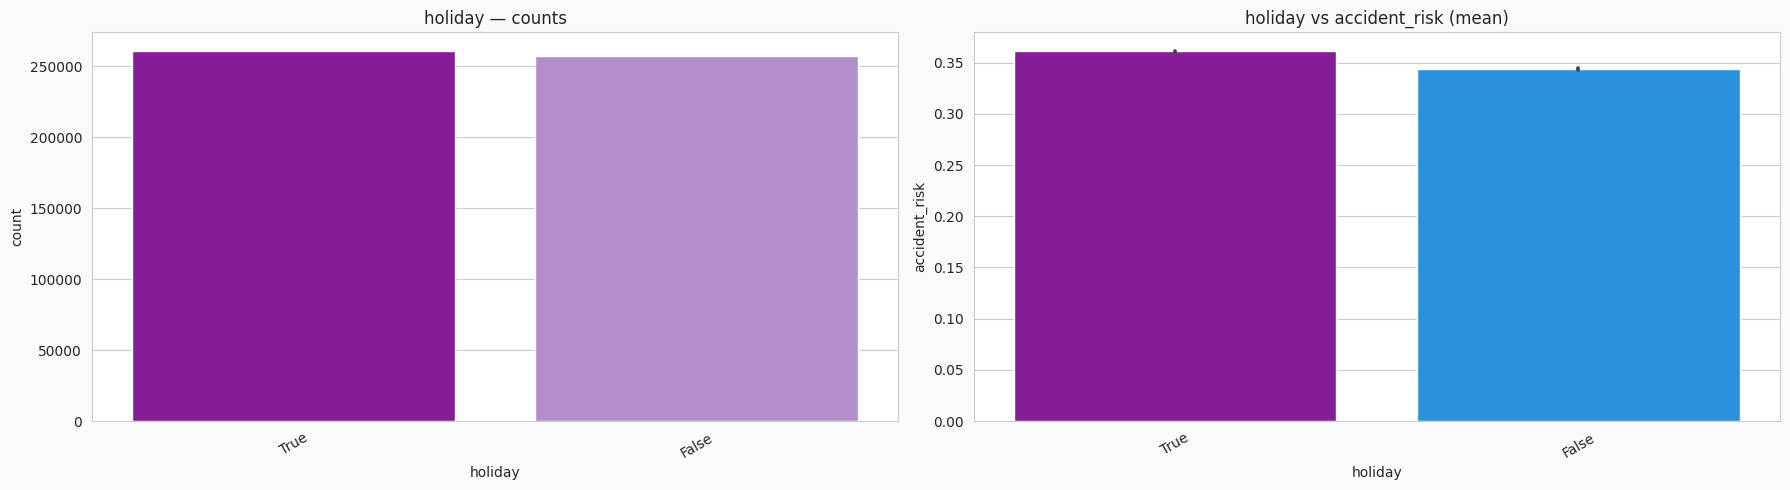

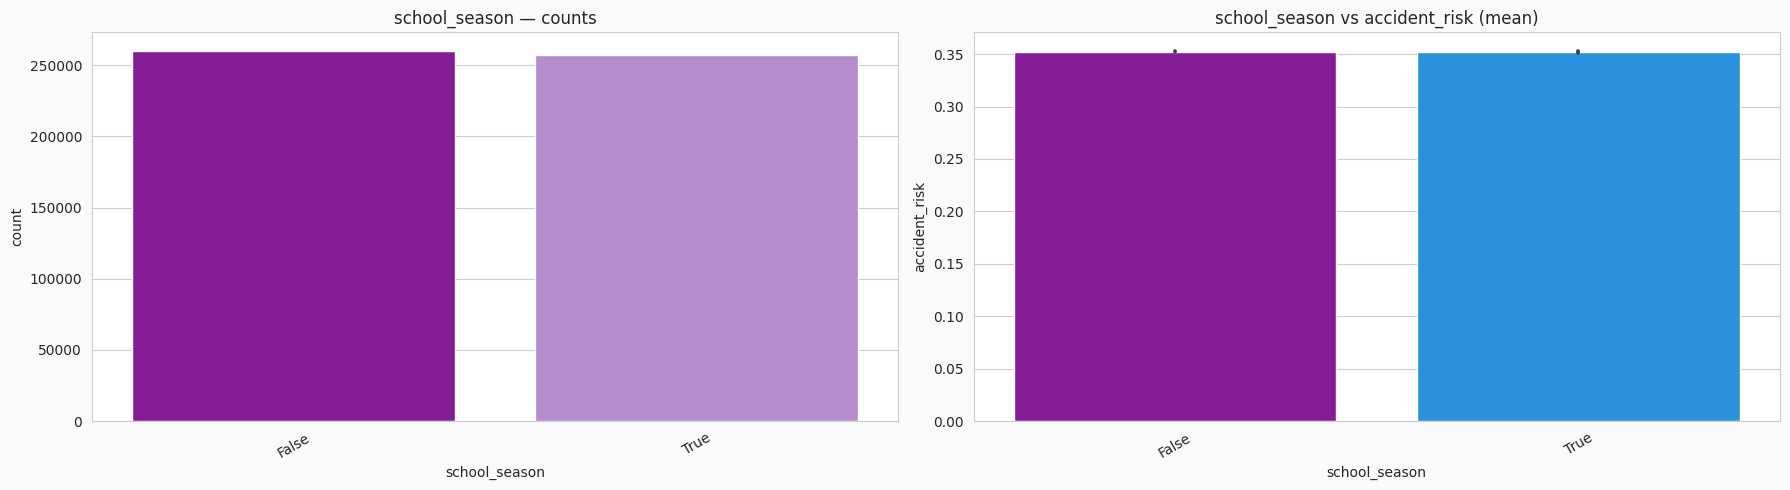

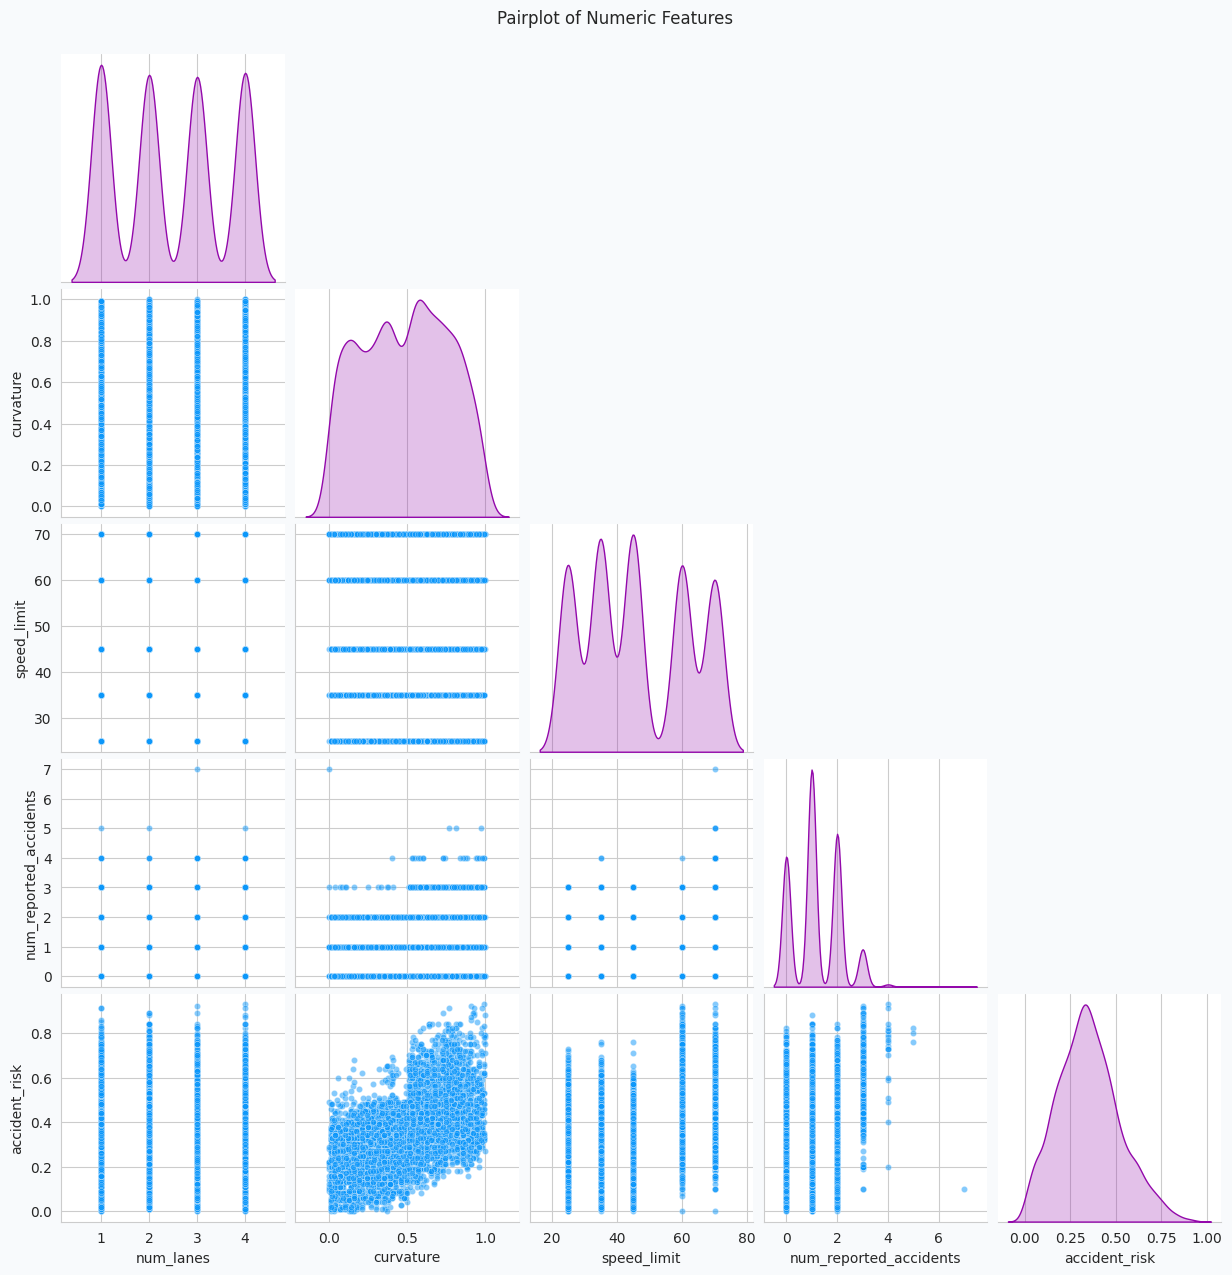

In [26]:

plot_missing_values(train_df)
plot_target_distribution(train_df, TARGET)
plot_correlation_heatmap(train_df, TARGET)
plot_numeric_distributions(train_df, numeric_cols, TARGET)
plot_categorical_summary(train_df, categorical_cols, TARGET)
numeric_for_pairplot = numeric_cols + [TARGET]
plot_pairgrid(train_df[numeric_for_pairplot], numeric_for_pairplot)


In [27]:

aggs = {}
for col in categorical_cols:
    stats = feature_group_statistics(train_df, col, TARGET)
    bilingual_print(
        f"Target statistics grouped by {col}.",
        f"Estadísticas del target agrupadas por {col}."
    )
    display(stats.head())
    aggs[col] = stats

bilingual_print(
    "Correlation between target and numeric features.",
    "Correlación entre el objetivo y las variables numéricas."
)
correlations = train_df[numeric_cols + [TARGET]].corr()[TARGET].sort_values(ascending=False)
display(correlations)


EN> Target statistics grouped by road_type.
ES> Estadísticas del target agrupadas por road_type.


,road_type,count,mean,median,std
2,urban,171363,0.3575,0.3500,0.1660
1,rural,172719,0.3500,0.3400,0.1672
0,highway,173672,0.3497,0.3400,0.1659


EN> Target statistics grouped by lighting.
ES> Estadísticas del target agrupadas por lighting.


,lighting,count,mean,median,std
2,night,155913,0.4705,0.4500,0.1580
0,daylight,178015,0.3029,0.3000,0.1428
1,dim,183826,0.3001,0.3000,0.1420


EN> Target statistics grouped by weather.
ES> Estadísticas del target agrupadas por weather.


,weather,count,mean,median,std
1,foggy,181463,0.3863,0.3700,0.1676
2,rainy,156985,0.3615,0.3500,0.1561
0,clear,179306,0.3101,0.3000,0.1649


EN> Target statistics grouped by road_signs_present.
ES> Estadísticas del target agrupadas por road_signs_present.


,road_signs_present,count,mean,median,std
1,True,258465,0.3525,0.3400,0.1671
0,False,259289,0.3523,0.3400,0.1657


EN> Target statistics grouped by public_road.
ES> Estadísticas del target agrupadas por public_road.


,public_road,count,mean,median,std
1,True,260045,0.3575,0.3500,0.1676
0,False,257709,0.3472,0.3400,0.1651


EN> Target statistics grouped by time_of_day.
ES> Estadísticas del target agrupadas por time_of_day.


,time_of_day,count,mean,median,std
1,evening,172837,0.3547,0.3400,0.1645
0,afternoon,171507,0.3514,0.3400,0.1675
2,morning,173410,0.3510,0.3400,0.1672


EN> Target statistics grouped by holiday.
ES> Estadísticas del target agrupadas por holiday.


,holiday,count,mean,median,std
1,True,260688,0.3608,0.3500,0.1678
0,False,257066,0.3438,0.3300,0.1645


EN> Target statistics grouped by school_season.
ES> Estadísticas del target agrupadas por school_season.


,school_season,count,mean,median,std
0,False,260164,0.3525,0.3400,0.1672
1,True,257590,0.3522,0.3400,0.1656


EN> Correlation between target and numeric features.
ES> Correlación entre el objetivo y las variables numéricas.


accident_risk             1.0000
curvature                 0.5439
speed_limit               0.4309
num_reported_accidents    0.2139
num_lanes                -0.0060
Name: accident_risk, dtype: float64

## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Data cleaning</p>
<a id="cleaning-agent"></a>

In [28]:

bool_columns = train_df.select_dtypes(include=["bool"]).columns.tolist()
if bool_columns:
    bilingual_print(
        f"Casting boolean columns to categorical: {bool_columns}",
        f"Convirtiendo columnas booleanas a categóricas: {bool_columns}"
    )
    train_df = convert_booleans_to_category(train_df, bool_columns)
    test_df = convert_booleans_to_category(test_df, bool_columns)

feature_groups = get_feature_groups(train_df, TARGET, ID_COLUMN)
feature_columns = [col for col in train_df.columns if col not in [TARGET, ID_COLUMN]]

preprocessor = build_preprocessor(feature_groups)

X = train_df[feature_columns].copy()
y = train_df[TARGET].copy()

test_features = test_df[feature_columns].copy()
test_ids = test_df[ID_COLUMN].copy()

bilingual_print(
    f"Prepared {len(feature_columns)} features for modelling.",
    f"Se prepararon {len(feature_columns)} características para el modelado."
)

feature_catalog = pd.DataFrame({
    "feature": feature_columns,
    "role": ["numeric" if col in feature_groups["numeric"] else "categorical" for col in feature_columns]
})
display(feature_catalog)


EN> Casting boolean columns to categorical: ['road_signs_present', 'public_road', 'holiday', 'school_season']
ES> Convirtiendo columnas booleanas a categóricas: ['road_signs_present', 'public_road', 'holiday', 'school_season']
EN> Prepared 12 features for modelling.
ES> Se prepararon 12 características para el modelado.


,feature,role
0,road_type,categorical
1,num_lanes,numeric
2,curvature,numeric
3,speed_limit,numeric
4,lighting,categorical
5,weather,categorical
6,road_signs_present,categorical
7,public_road,categorical
8,time_of_day,categorical
9,holiday,categorical


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Model selection</p>
<a id="model-agent"></a>

In [29]:

candidate_models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=500, random_state=SEED, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=SEED),
    "LGBMRegressor": LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=SEED
    ),
    "XGBRegressor": XGBRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=SEED,
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1
    ),
}

bilingual_print(
    f"Evaluating {len(candidate_models)} candidate models with {N_SPLITS}-fold CV.",
    f"Evaluando {len(candidate_models)} modelos candidatos con CV de {N_SPLITS} folds."
)
leaderboard = evaluate_models(candidate_models, X, y, preprocessor, n_splits=N_SPLITS)
display(leaderboard)

best_model_name = leaderboard.loc[0, "model"]
bilingual_print(
    f"Best CV model: {best_model_name}",
    f"Mejor modelo según CV: {best_model_name}"
)


EN> Evaluating 5 candidate models with 5-fold CV.
ES> Evaluando 5 modelos candidatos con CV de 5 folds.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 24
[LightGBM] [Info] Start training from score 0.352645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 24
[LightGBM] [Info] Start training from score 0.352376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

,model,rmse_mean,rmse_std,mae_mean,fit_time_sec
0,LGBMRegressor,0.0561,0.0002,0.0436,101.6115
1,XGBRegressor,0.0561,0.0002,0.0436,151.7606
2,GradientBoostingRegressor,0.0569,0.0002,0.0443,443.8156
3,RandomForestRegressor,0.0591,0.0002,0.0459,2203.2632
4,LinearRegression,0.0735,0.0002,0.0584,13.4352


EN> Best CV model: LGBMRegressor
ES> Mejor modelo según CV: LGBMRegressor


In [30]:

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

best_model = candidate_models[best_model_name]
best_pipeline = train_best_pipeline(best_model, preprocessor, X_train, y_train)

holdout_metrics = evaluate_holdout(best_pipeline, X_valid, y_valid)
bilingual_print(
    f"Hold-out RMSE: {holdout_metrics['rmse']:.4f} | MAE: {holdout_metrics['mae']:.4f} | R2: {holdout_metrics['r2']:.4f}",
    f"Hold-out RMSE: {holdout_metrics['rmse']:.4f} | MAE: {holdout_metrics['mae']:.4f} | R2: {holdout_metrics['r2']:.4f}"
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 24
[LightGBM] [Info] Start training from score 0.352645
EN> Hold-out RMSE: 0.0561 | MAE: 0.0436 | R2: 0.8867
ES> Hold-out RMSE: 0.0561 | MAE: 0.0436 | R2: 0.8867


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Submission</p>
<a id="submission-agent"></a>

In [31]:

final_pipeline = train_best_pipeline(best_model, preprocessor, X, y)
submission_df = generate_submission(final_pipeline, test_features, test_ids, TARGET)

bilingual_print(
    f"Submission saved with shape {submission_df.shape}",
    f"Submission guardada con forma {submission_df.shape}"
)

display(submission_df.head())
print("Missing values per column:")
print(submission_df.isna().sum())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 24
[LightGBM] [Info] Start training from score 0.352377
EN> Submission saved with shape (172585, 2)
ES> Submission guardada con forma (172585, 2)


,id,accident_risk
0,517754,0.2903
1,517755,0.1230
2,517756,0.1893
3,517757,0.3145
4,517758,0.3991


Missing values per column:
id               0
accident_risk    0
dtype: int64
